In [30]:
import pandas as pd 
import matplotlib.pyplot as plt 
import numpy as np
import seaborn as sns

In [31]:
date_cols = [
    'Auftragseingang', 
    'Auftragsende_SOLL',
    'AFO_Start_SOLL',
    'AFO_Ende_SOLL',
    'AFO_Start_IST',
    'AFO_Ende_IST'
]

data = pd.read_csv(
    '../data/processed/data_cleaned_timestamp_1.csv',
    parse_dates=date_cols,
    sep=',',
    low_memory=False
)

In [32]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1527971 entries, 0 to 1527970
Data columns (total 15 columns):
 #   Column                     Non-Null Count    Dtype         
---  ------                     --------------    -----         
 0   AuftragsID                 1527971 non-null  object        
 1   BauteilID                  1527971 non-null  int64         
 2   Bauteilbezeichnung         1527971 non-null  object        
 3   Auftragseingang            1527971 non-null  datetime64[ns]
 4   Priorität                  1527971 non-null  int64         
 5   Auftragsende_SOLL          1527971 non-null  datetime64[ns]
 6   Arbeitsschritt             1527971 non-null  int64         
 7   Arbeitsschrittbezeichnung  1527971 non-null  object        
 8   AFO_Start_SOLL             1527971 non-null  datetime64[ns]
 9   AFO_Ende_SOLL              1527971 non-null  datetime64[ns]
 10  AFO_Start_IST              1527971 non-null  datetime64[ns]
 11  AFO_Ende_IST               1527971 no

In [33]:
missing = data.isna().sum().sort_values(ascending=False)
missing.head(10)

Maschinenkapazität      989584
Maschinenbezeichnung    988820
MaschinenID             299544
AuftragsID                   0
BauteilID                    0
Bauteilbezeichnung           0
Auftragseingang              0
Priorität                    0
Auftragsende_SOLL            0
Arbeitsschritt               0
dtype: int64

In [34]:
# Fehlende Maschineninformationen treten ausschließlich bei den Arbeitsschritten 'Info' und 'End' auf.
# Diese Schritte repräsentieren keine realen Bearbeitungsprozesse,
# sondern systemische Platzhalter (Start-/Endmarken). 
# Für Analysen produktiver Vorgänge werden sie entfernt oder separat markiert.

pd.crosstab(
    data["Arbeitsschrittbezeichnung"],
    data["MaschinenID"].isna(),
    normalize="index"
).sort_values(by=True, ascending=False).head(15)


MaschinenID,False,True
Arbeitsschrittbezeichnung,,
End,0.000000,1.000000
Info,0.005007,0.994993
Abspannen-Nacharbeiten,1.000000,0.000000
Aufspannen,1.000000,0.000000
Heften-Schweißen,1.000000,0.000000
Lackieren,1.000000,0.000000
Mechanisch Bearbeiten,1.000000,0.000000
Nachschweißen,1.000000,0.000000
Richten,1.000000,0.000000


In [35]:
machine_overview = (
    data
    .dropna(subset=["MaschinenID"])
    .drop_duplicates(subset=["MaschinenID"])
    .loc[:, ["MaschinenID", "Maschinenbezeichnung", "Maschinenkapazität"]]
    .sort_values("MaschinenID")
)
machine_overview

,MaschinenID,Maschinenbezeichnung,Maschinenkapazität
1310,-,XXX,NaN
78,1,EWM,16.0
75,2,Fronius,2.0
79,3,Deckel Maho,8.0
82,4,DMG Mori,8.0
328,5,Lorch,4.0
36,Transport/Rüsten,NaN,NaN


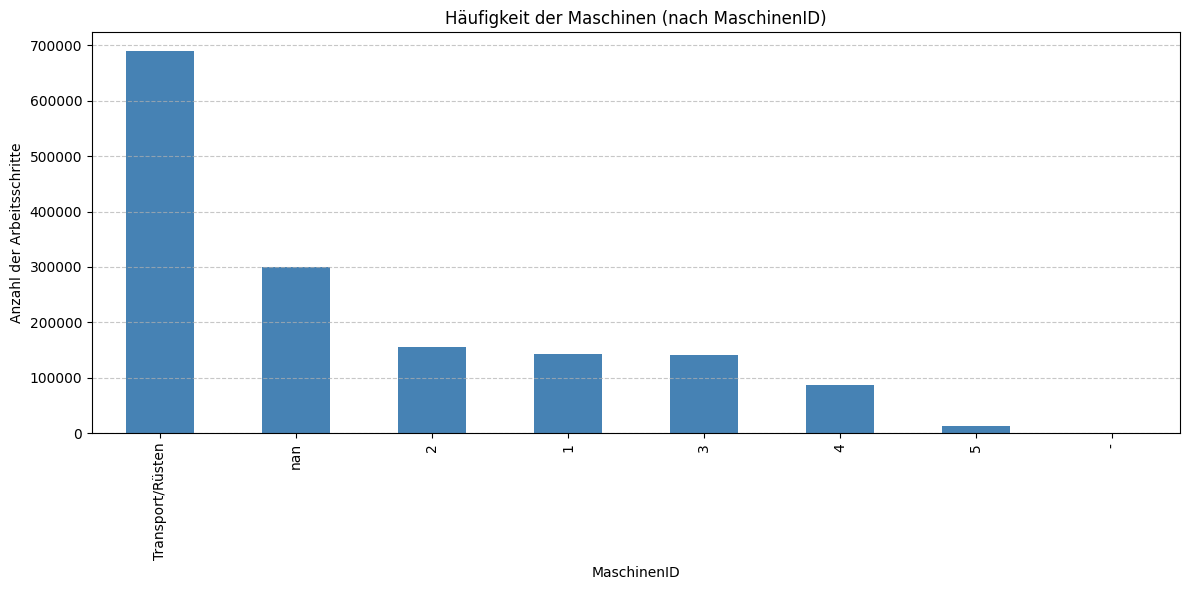

In [36]:
# Maschinenverwendung zählen
machine_counts = (
    data["MaschinenID"]
    .value_counts(dropna=False)   # NaN mit anzeigen
    .sort_values(ascending=False)
)

# Plot
plt.figure(figsize=(12,6))
machine_counts.plot(kind="bar", color="steelblue")
plt.title("Häufigkeit der Maschinen (nach MaschinenID)")
plt.xlabel("MaschinenID")
plt.ylabel("Anzahl der Arbeitsschritte")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

In [37]:
check_machine_consistency = (
    data
    .groupby("MaschinenID")[["Maschinenbezeichnung", "Maschinenkapazität"]]
    .nunique()
    .sort_values("Maschinenbezeichnung", ascending=False)
)

check_machine_consistency.head(10)


,Maschinenbezeichnung,Maschinenkapazität
MaschinenID,,
-,1,1
1,1,18
2,1,25
3,1,1
4,1,8
5,1,1
Transport/Rüsten,0,0


In [38]:
# Prüfen, welche Kombinationen fehlen
mask_id_no_name = data["MaschinenID"].notna() & data["Maschinenbezeichnung"].isna()
mask_name_no_id = data["MaschinenID"].isna() & data["Maschinenbezeichnung"].notna()

# Anzahl beider Fälle
print("MaschinenID vorhanden, aber Bezeichnung fehlt:", mask_id_no_name.sum())
print("Maschinenbezeichnung vorhanden, aber ID fehlt:", mask_name_no_id.sum())


MaschinenID vorhanden, aber Bezeichnung fehlt: 689276
Maschinenbezeichnung vorhanden, aber ID fehlt: 0


In [39]:
# Gruppierte Übersicht: Wie oft pro ID Bezeichnung und Kapazität vorhanden oder fehlt
maschine_status = (
    data.groupby("MaschinenID")
    .apply(lambda x: pd.Series({
        "Bezeichnung_vorhanden": x["Maschinenbezeichnung"].notna().sum(),
        "Bezeichnung_fehlend": x["Maschinenbezeichnung"].isna().sum(),
        "Kapazität_vorhanden": x["Maschinenkapazität"].notna().sum(),
        "Kapazität_fehlend": x["Maschinenkapazität"].isna().sum(),
        "Gesamt": len(x)
    }))
    .reset_index()
    .sort_values(by="Bezeichnung_fehlend", ascending=False)
)

# Fehlraten berechnen (optional)
maschine_status["Fehlrate_Bezeichnung_%"] = (
    maschine_status["Bezeichnung_fehlend"] / maschine_status["Gesamt"] * 100
).round(2)

maschine_status["Fehlrate_Kapazität_%"] = (
    maschine_status["Kapazität_fehlend"] / maschine_status["Gesamt"] * 100
).round(2)

maschine_status.head(10)


/var/folders/mc/jb1nbgjx243512nh0dbf14km0000gn/T/ipykernel_979/2660534264.py:4: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: pd.Series({


,MaschinenID,Bezeichnung_vorhanden,Bezeichnung_fehlend,Kapazität_vorhanden,Kapazität_fehlend,Gesamt,Fehlrate_Bezeichnung_%,Fehlrate_Kapazität_%
6,Transport/Rüsten,0,689276,0,689276,689276,100.0,100.00
0,-,776,0,12,764,776,0.0,98.45
1,1,143099,0,143099,0,143099,0.0,0.00
2,2,155119,0,155119,0,155119,0.0,0.00
3,3,140803,0,140803,0,140803,0.0,0.00
4,4,86037,0,86037,0,86037,0.0,0.00
5,5,13317,0,13317,0,13317,0.0,0.00


In [40]:
mask_name_no_id = ((data["MaschinenID"].isna()) | (data["MaschinenID"] == '-')) & data["Maschinenbezeichnung"].notna()
data[mask_name_no_id]

,AuftragsID,BauteilID,Bauteilbezeichnung,Auftragseingang,Priorität,Auftragsende_SOLL,Arbeitsschritt,Arbeitsschrittbezeichnung,AFO_Start_SOLL,AFO_Ende_SOLL,AFO_Start_IST,AFO_Ende_IST,MaschinenID,Maschinenbezeichnung,Maschinenkapazität
1310,13955c8a3e7746cdaa39b6d19a3d7391,1,Steuerventilmodul,2013-09-11,1,2014-01-06 13:12:00,1,Info,2014-01-06 07:00:00,2014-01-06 07:01:00,2014-01-06 07:00:00,2014-01-06 07:01:00,-,XXX,NaN
3339,c0d2f3772f8748f09d8c4dfcff143c7b,1,Steuerventilmodul,2013-08-27,1,2013-09-06 13:12:00,31,Nachschweißen,2013-09-06 11:01:00,2013-09-06 12:41:00,2014-01-09 07:26:00,2014-01-09 08:39:00,-,XXX,8.0
3731,dad9abed9910476e898ce3d684faadf7,1,Steuerventilmodul,2013-06-15,1,2013-09-09 12:42:00,31,Nachschweißen,2013-09-09 11:01:00,2013-09-09 12:11:00,2014-01-09 11:52:00,2014-01-09 12:45:00,-,XXX,8.0
4124,b23fa6f7bc3d48d6b14a1dfacc9040dc,2,Schwenkzylinder,2013-08-25,1,2013-09-10 08:02:00,42,Abspannen-Nacharbeiten,2013-09-09 08:31:00,2013-09-10 07:31:00,2014-01-10 07:17:00,2014-01-10 08:34:00,-,XXX,8.0
8578,e4ddb92733c845a59b6a8a095f0709f3,2,Schwenkzylinder,2013-09-20,3,2014-01-27 13:12:00,1,Info,2014-01-27 07:00:00,2014-01-27 07:01:00,2014-01-27 07:00:00,2014-01-27 07:01:00,-,XXX,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1522660,6e8f229b094747e5bd297237cbceffba,2,Schwenkzylinder,2024-07-01,1,2024-07-29 09:02:00,1,Info,2024-07-24 07:00:00,2024-07-24 07:01:00,2024-07-24 07:00:00,2024-07-24 07:01:00,-,XXX,NaN
1525788,83d5d080ac3a447abe702488cc8ef609,1,Steuerventilmodul,2024-03-25,3,2024-08-01 08:32:00,1,Info,2024-07-31 07:00:00,2024-07-31 07:01:00,2024-07-31 07:00:00,2024-07-31 07:01:00,-,XXX,NaN
1525826,2455c54e01ab4f23add690272c4adc22,2,Schwenkzylinder,2024-04-23,2,2024-08-01 11:02:00,1,Info,2024-07-31 07:00:00,2024-07-31 07:01:00,2024-07-31 07:00:00,2024-07-31 07:01:00,-,XXX,NaN
1525833,7dc6b21ec1784387bd1064537c19b83e,2,Schwenkzylinder,2024-03-25,1,2024-08-01 12:42:00,1,Info,2024-07-31 07:00:00,2024-07-31 07:01:00,2024-07-31 07:00:00,2024-07-31 07:01:00,-,XXX,NaN


In [41]:
# MaschinenID "Transport/Rüsten" hat keine Bezeichnung und Kapazität
# Kein echter Maschinenenprozess, wahrscheinlich zwischenschritt 

# 1) Boolean-Flag für Transport/Rüsten setzen (robust gegen Groß-/Kleinschreibung & Spaces)
is_transport = (
    data["MaschinenID"].astype(str).str.strip().str.lower() == "transport/rüsten"
)
data["is_transport_ruesten"] = is_transport

# 2) Für Transport/Rüsten die MaschinenID (und optional Bezeichnung/Kapazität) auf NaN setzen
data.loc[is_transport, "MaschinenID"] = pd.NA
data.loc[is_transport, "Maschinenbezeichnung"] = pd.NA   # optional, empfehlenswert
data.loc[is_transport, "Maschinenkapazität"] = pd.NA     # optional, empfehlenswert

# 3) Kontrolle
print("Transport/Rüsten-Zeilen:", is_transport.sum())
print("MaschinenID nun NaN in diesen Zeilen:",
      data.loc[is_transport, "MaschinenID"].isna().all())
print("Bezeichnung nun NaN in diesen Zeilen:",
      data.loc[is_transport, "Maschinenbezeichnung"].isna().all())
print("Kapazität nun NaN in diesen Zeilen:",
      data.loc[is_transport, "Maschinenkapazität"].isna().all())


# Alle NaN (NumPy) durch Pandas-NA ersetzen
data = data.replace({np.nan: pd.NA})

# Optional: sicherstellen, dass die Spalte einen "nullable" dtype hat
data["MaschinenID"] = data["MaschinenID"].astype("string")


Transport/Rüsten-Zeilen: 689276
MaschinenID nun NaN in diesen Zeilen: True
Bezeichnung nun NaN in diesen Zeilen: True
Kapazität nun NaN in diesen Zeilen: True


In [42]:
data["is_transport_ruesten"].value_counts()

is_transport_ruesten
False    838695
True     689276
Name: count, dtype: int64

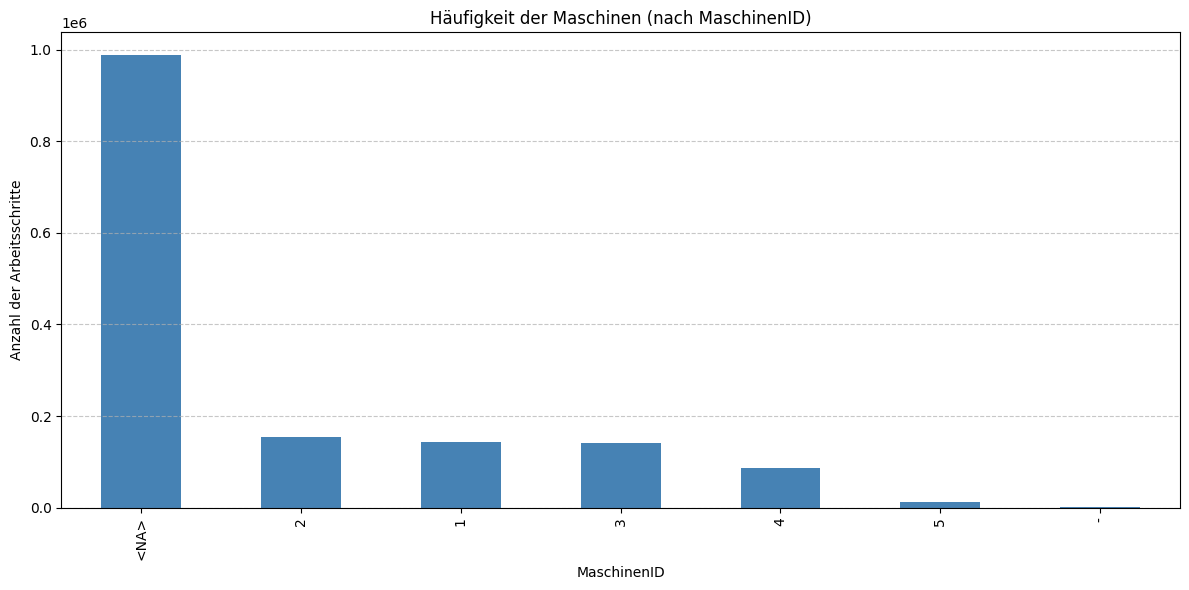

In [43]:
# Maschinenverwendung zählen
machine_counts = (
    data["MaschinenID"]
    .value_counts(dropna=False)   # NaN mit anzeigen
    .sort_values(ascending=False)
)

# Plot
plt.figure(figsize=(12,6))
machine_counts.plot(kind="bar", color="steelblue")
plt.title("Häufigkeit der Maschinen (nach MaschinenID)")
plt.xlabel("MaschinenID")
plt.ylabel("Anzahl der Arbeitsschritte")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

In [44]:
mask_dash = data["MaschinenID"].astype(str).str.strip() == "-"
data_dash = data[mask_dash]

print("Anzahl der Zeilen mit MaschinenID='-':", mask_dash.sum())
data_dash[["MaschinenID", "Maschinenbezeichnung", "Maschinenkapazität"]].head()


Anzahl der Zeilen mit MaschinenID='-': 776


,MaschinenID,Maschinenbezeichnung,Maschinenkapazität
1310,-,XXX,<NA>
3339,-,XXX,8.0
3731,-,XXX,8.0
4124,-,XXX,8.0
8578,-,XXX,<NA>


In [45]:
data.loc[mask_dash]

,AuftragsID,BauteilID,Bauteilbezeichnung,Auftragseingang,Priorität,Auftragsende_SOLL,Arbeitsschritt,Arbeitsschrittbezeichnung,AFO_Start_SOLL,AFO_Ende_SOLL,AFO_Start_IST,AFO_Ende_IST,MaschinenID,Maschinenbezeichnung,Maschinenkapazität,is_transport_ruesten
1310,13955c8a3e7746cdaa39b6d19a3d7391,1,Steuerventilmodul,2013-09-11,1,2014-01-06 13:12:00,1,Info,2014-01-06 07:00:00,2014-01-06 07:01:00,2014-01-06 07:00:00,2014-01-06 07:01:00,-,XXX,<NA>,False
3339,c0d2f3772f8748f09d8c4dfcff143c7b,1,Steuerventilmodul,2013-08-27,1,2013-09-06 13:12:00,31,Nachschweißen,2013-09-06 11:01:00,2013-09-06 12:41:00,2014-01-09 07:26:00,2014-01-09 08:39:00,-,XXX,8.0,False
3731,dad9abed9910476e898ce3d684faadf7,1,Steuerventilmodul,2013-06-15,1,2013-09-09 12:42:00,31,Nachschweißen,2013-09-09 11:01:00,2013-09-09 12:11:00,2014-01-09 11:52:00,2014-01-09 12:45:00,-,XXX,8.0,False
4124,b23fa6f7bc3d48d6b14a1dfacc9040dc,2,Schwenkzylinder,2013-08-25,1,2013-09-10 08:02:00,42,Abspannen-Nacharbeiten,2013-09-09 08:31:00,2013-09-10 07:31:00,2014-01-10 07:17:00,2014-01-10 08:34:00,-,XXX,8.0,False
8578,e4ddb92733c845a59b6a8a095f0709f3,2,Schwenkzylinder,2013-09-20,3,2014-01-27 13:12:00,1,Info,2014-01-27 07:00:00,2014-01-27 07:01:00,2014-01-27 07:00:00,2014-01-27 07:01:00,-,XXX,<NA>,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1522660,6e8f229b094747e5bd297237cbceffba,2,Schwenkzylinder,2024-07-01,1,2024-07-29 09:02:00,1,Info,2024-07-24 07:00:00,2024-07-24 07:01:00,2024-07-24 07:00:00,2024-07-24 07:01:00,-,XXX,<NA>,False
1525788,83d5d080ac3a447abe702488cc8ef609,1,Steuerventilmodul,2024-03-25,3,2024-08-01 08:32:00,1,Info,2024-07-31 07:00:00,2024-07-31 07:01:00,2024-07-31 07:00:00,2024-07-31 07:01:00,-,XXX,<NA>,False
1525826,2455c54e01ab4f23add690272c4adc22,2,Schwenkzylinder,2024-04-23,2,2024-08-01 11:02:00,1,Info,2024-07-31 07:00:00,2024-07-31 07:01:00,2024-07-31 07:00:00,2024-07-31 07:01:00,-,XXX,<NA>,False
1525833,7dc6b21ec1784387bd1064537c19b83e,2,Schwenkzylinder,2024-03-25,1,2024-08-01 12:42:00,1,Info,2024-07-31 07:00:00,2024-07-31 07:01:00,2024-07-31 07:00:00,2024-07-31 07:01:00,-,XXX,<NA>,False


In [46]:
# Maske für MaschinenID '-'
mask_dash = data["MaschinenID"].astype(str).str.strip() == "-"

# Anzahl der Zeilen anzeigen
print("Anzahl der Zeilen mit MaschinenID='-':", mask_dash.sum())

# Relevante Spalten anzeigen
data.loc[
    mask_dash,
    ["MaschinenID", "Maschinenbezeichnung","Maschinenkapazität", "Arbeitsschrittbezeichnung"]
]


Anzahl der Zeilen mit MaschinenID='-': 776


,MaschinenID,Maschinenbezeichnung,Maschinenkapazität,Arbeitsschrittbezeichnung
1310,-,XXX,<NA>,Info
3339,-,XXX,8.0,Nachschweißen
3731,-,XXX,8.0,Nachschweißen
4124,-,XXX,8.0,Abspannen-Nacharbeiten
8578,-,XXX,<NA>,Info
...,...,...,...,...
1522660,-,XXX,<NA>,Info
1525788,-,XXX,<NA>,Info
1525826,-,XXX,<NA>,Info
1525833,-,XXX,<NA>,Info


In [47]:
# Maske für MaschinenID '-'
mask_dash = data["MaschinenID"].astype(str).str.strip() == "-"

# Subset
df_dash = data.loc[mask_dash, ["MaschinenID", "Maschinenkapazität", "Arbeitsschrittbezeichnung"]]

# Getrennte Auswertung für NA und 8.0
df_na = df_dash[df_dash["Maschinenkapazität"].isna()]
df_8  = df_dash[df_dash["Maschinenkapazität"] == 8.0]

print("🔹 MaschinenID='-' mit Maschinenkapazität <NA>:")
print(df_na["Arbeitsschrittbezeichnung"].value_counts(dropna=False))
print("\nEindeutige Arbeitsschritte:", df_na["Arbeitsschrittbezeichnung"].nunique())

print("\n🔹 MaschinenID='-' mit Maschinenkapazität 8.0:")
print(df_8["Arbeitsschrittbezeichnung"].value_counts(dropna=False))
print("\nEindeutige Arbeitsschritte:", df_8["Arbeitsschrittbezeichnung"].nunique())


🔹 MaschinenID='-' mit Maschinenkapazität <NA>:
Arbeitsschrittbezeichnung
Info    764
Name: count, dtype: int64

Eindeutige Arbeitsschritte: 1

🔹 MaschinenID='-' mit Maschinenkapazität 8.0:
Arbeitsschrittbezeichnung
Nachschweißen             6
Abspannen-Nacharbeiten    6
Name: count, dtype: int64

Eindeutige Arbeitsschritte: 2


In [48]:
# 🎯 Bedingung: MaschinenID = '-' UND Arbeitsschrittbezeichnung = 'Info'
mask_info = (
    data["MaschinenID"].astype(str).str.strip() == "-"
) & (
    data["Arbeitsschrittbezeichnung"].astype(str).str.strip().str.lower() == "info"
)

# 🧮 Kontrollausgabe
print("Anzahl betroffener Zeilen (MaschinenID='-' & Arbeitsschrittbezeichnung='Info'):", mask_info.sum())

# 🆕 Neue Spalte 'info' hinzufügen mit kurzer Notiz
data.loc[mask_info, "info"] = "MaschinenID '-' + Arbeitsschritt='Info' (Platzhalter, kein Maschinenprozess)"

# 🧹 Maschinenfelder auf NaN setzen
data.loc[mask_info, ["MaschinenID", "Maschinenbezeichnung", "Maschinenkapazität"]] = pd.NA

# ✅ Kontrolle
print("MaschinenID nun NaN:", data.loc[mask_info, "MaschinenID"].isna().all())
print("Neue Info-Spalte gesetzt:", data.loc[mask_info, "info"].notna().all())

Anzahl betroffener Zeilen (MaschinenID='-' & Arbeitsschrittbezeichnung='Info'): 764
MaschinenID nun NaN: True
Neue Info-Spalte gesetzt: True


In [49]:


# 🎯 Filter: Kapazität = 8.0 UND Arbeitsschritt in ['Nachschweißen', 'Abspannen-Nacharbeiten']
mask = (
    (data["Maschinenkapazität"] == 8.0) &
    (data["Arbeitsschrittbezeichnung"].isin(["Nachschweißen", "Abspannen-Nacharbeiten"]))
)

# 🔍 Gefilterte Daten
df_filtered = data.loc[mask, ["MaschinenID", "Maschinenbezeichnung", "Arbeitsschrittbezeichnung", "Maschinenkapazität"]]

# 🧮 Gruppieren und zählen
machine_counts = (
    df_filtered.groupby(["MaschinenID", "Maschinenbezeichnung", "Arbeitsschrittbezeichnung","Maschinenkapazität"])
    .size()
    .reset_index(name="Einsatz_Häufigkeit")
    .sort_values("Einsatz_Häufigkeit", ascending=False)
)

# 📋 Ergebnisse anzeigen
print("Anzahl der relevanten Zeilen:", len(df_filtered))
machine_counts.head(10)


Anzahl der relevanten Zeilen: 140815


,MaschinenID,Maschinenbezeichnung,Arbeitsschrittbezeichnung,Maschinenkapazität,Einsatz_Häufigkeit
2,3,Deckel Maho,Abspannen-Nacharbeiten,8.0,76350
3,3,Deckel Maho,Nachschweißen,8.0,64453
0,-,XXX,Abspannen-Nacharbeiten,8.0,6
1,-,XXX,Nachschweißen,8.0,6


In [50]:
# Maske für die 12 fehlerhaften Einträge
mask_fix = (
    (data["MaschinenID"].astype(str).str.strip() == "-") &
    (data["Maschinenbezeichnung"].astype(str).str.strip() == "XXX") &
    (data["Maschinenkapazität"] == 8.0) &
    (data["Arbeitsschrittbezeichnung"].isin(["Nachschweißen", "Abspannen-Nacharbeiten"]))
)

# Optional: Kontrolle
print("Anzahl der betroffenen Zeilen:", mask_fix.sum())

# Korrektur durchführen
data.loc[mask_fix, "MaschinenID"] = "3"
data.loc[mask_fix, "Maschinenbezeichnung"] = "Deckel Maho"

# Info-Spalte ergänzen, damit die Änderung nachvollziehbar bleibt
data.loc[mask_fix, "info"] = "MaschinenID '-' (XXX) korrigiert zu 'Deckel Maho' basierend auf Kapazität=8.0 & Arbeitsschritt"

# Kontrolle nachher
data.loc[mask_fix, ["MaschinenID", "Maschinenbezeichnung", "Arbeitsschrittbezeichnung", "info"]]


Anzahl der betroffenen Zeilen: 12


,MaschinenID,Maschinenbezeichnung,Arbeitsschrittbezeichnung,info
3339,3,Deckel Maho,Nachschweißen,MaschinenID '-' (XXX) korrigiert zu 'Deckel Ma...
3731,3,Deckel Maho,Nachschweißen,MaschinenID '-' (XXX) korrigiert zu 'Deckel Ma...
4124,3,Deckel Maho,Abspannen-Nacharbeiten,MaschinenID '-' (XXX) korrigiert zu 'Deckel Ma...
11188,3,Deckel Maho,Abspannen-Nacharbeiten,MaschinenID '-' (XXX) korrigiert zu 'Deckel Ma...
17807,3,Deckel Maho,Nachschweißen,MaschinenID '-' (XXX) korrigiert zu 'Deckel Ma...
20062,3,Deckel Maho,Abspannen-Nacharbeiten,MaschinenID '-' (XXX) korrigiert zu 'Deckel Ma...
20813,3,Deckel Maho,Abspannen-Nacharbeiten,MaschinenID '-' (XXX) korrigiert zu 'Deckel Ma...
24781,3,Deckel Maho,Nachschweißen,MaschinenID '-' (XXX) korrigiert zu 'Deckel Ma...
39155,3,Deckel Maho,Abspannen-Nacharbeiten,MaschinenID '-' (XXX) korrigiert zu 'Deckel Ma...
39306,3,Deckel Maho,Abspannen-Nacharbeiten,MaschinenID '-' (XXX) korrigiert zu 'Deckel Ma...


In [51]:
machine_overview = (
    data
    .dropna(subset=["MaschinenID"])
    .drop_duplicates(subset=["MaschinenID"])
    .loc[:, ["MaschinenID", "Maschinenbezeichnung", "Maschinenkapazität"]]
    .sort_values("MaschinenID")
)
machine_overview

,MaschinenID,Maschinenbezeichnung,Maschinenkapazität
78,1,EWM,16.0
75,2,Fronius,2.0
79,3,Deckel Maho,8.0
82,4,DMG Mori,8.0
328,5,Lorch,4.0


In [52]:
for mid in ["1", "2", "4"]:
    print(mid)
    print(data.loc[data["MaschinenID"]==mid, "Maschinenkapazität"].value_counts().sort_index().head(20))
    print("-"*30)


1
Maschinenkapazität
1.0      1154
2.0      1478
3.0      1703
4.0      2007
5.0      3153
6.0      5625
7.0      8862
8.0     10459
9.0      9083
10.0     6311
11.0     4552
12.0     3590
13.0     3129
14.0     2899
15.0     2423
16.0     2337
17.0     2378
18.0    71956
Name: count, dtype: int64
------------------------------
2
Maschinenkapazität
1.0      1494
2.0      2237
3.0      2321
4.0      2447
5.0      3211
6.0      5032
7.0      7805
8.0     10593
9.0     11836
10.0    10898
11.0     8641
12.0     6707
13.0     5656
14.0     5287
15.0     5641
16.0     6365
17.0     7272
18.0     8495
19.0     8963
20.0     8096
Name: count, dtype: int64
------------------------------
4
Maschinenkapazität
1.0      220
2.0      342
3.0      400
4.0      528
5.0      592
6.0      599
7.0      725
8.0    82631
Name: count, dtype: int64
------------------------------


In [53]:
# 🕒 Sicherstellen, dass dein Datum als Datetime vorliegt
data["AFO_Start_IST"] = pd.to_datetime(data["AFO_Start_IST"], errors="coerce")

# 🧩 Relevante Spalten
df_time = data[["MaschinenID", "Maschinenkapazität", "AFO_Start_IST"]].dropna(subset=["MaschinenID", "Maschinenkapazität", "AFO_Start_IST"])

# 🧮 Gruppieren: Erste & letzte Verwendung jeder Kapazität pro Maschine
kapaz_hist = (
    df_time.groupby(["MaschinenID", "Maschinenkapazität"])["AFO_Start_IST"]
    .agg(["min", "max", "count"])
    .reset_index()
    .sort_values(["MaschinenID", "min"])
)

kapaz_hist.head(20)

,MaschinenID,Maschinenkapazität,min,max,count
15,1,16.0,2014-01-01 07:31:00,2024-07-30 11:34:00,2337
16,1,17.0,2014-01-01 07:39:00,2024-07-30 11:26:00,2378
1,1,2.0,2014-01-01 08:53:00,2024-07-12 09:06:00,1478
2,1,3.0,2014-01-01 08:54:00,2024-07-12 09:08:00,1703
3,1,4.0,2014-01-01 08:57:00,2024-08-02 07:10:00,2007
4,1,5.0,2014-01-01 09:01:00,2024-07-31 14:57:00,3153
5,1,6.0,2014-01-01 09:06:00,2024-08-02 12:47:00,5625
7,1,8.0,2014-01-01 09:08:00,2024-08-02 13:51:00,10459
8,1,9.0,2014-01-01 09:19:00,2024-08-02 13:53:00,9083
0,1,1.0,2014-01-01 14:53:00,2024-07-12 09:02:00,1154


In [54]:
machine_overview = (
    data
    .dropna(subset=["MaschinenID"])
    .drop_duplicates(subset=["MaschinenID"])
    .loc[:, ["MaschinenID", "Maschinenbezeichnung", "Maschinenkapazität"]]
    .sort_values("MaschinenID")
)
machine_overview

,MaschinenID,Maschinenbezeichnung,Maschinenkapazität
78,1,EWM,16.0
75,2,Fronius,2.0
79,3,Deckel Maho,8.0
82,4,DMG Mori,8.0
328,5,Lorch,4.0


In [55]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1527971 entries, 0 to 1527970
Data columns (total 17 columns):
 #   Column                     Non-Null Count    Dtype         
---  ------                     --------------    -----         
 0   AuftragsID                 1527971 non-null  object        
 1   BauteilID                  1527971 non-null  int64         
 2   Bauteilbezeichnung         1527971 non-null  object        
 3   Auftragseingang            1527971 non-null  datetime64[ns]
 4   Priorität                  1527971 non-null  int64         
 5   Auftragsende_SOLL          1527971 non-null  datetime64[ns]
 6   Arbeitsschritt             1527971 non-null  int64         
 7   Arbeitsschrittbezeichnung  1527971 non-null  object        
 8   AFO_Start_SOLL             1527971 non-null  datetime64[ns]
 9   AFO_Ende_SOLL              1527971 non-null  datetime64[ns]
 10  AFO_Start_IST              1527971 non-null  datetime64[ns]
 11  AFO_Ende_IST               1527971 no

In [56]:
data['BauteilID'] = data['BauteilID'].astype('Int64')
data['MaschinenID'] = data['MaschinenID'].astype('Int64')
data['Priorität'] = data['Priorität'].astype('Int64')

In [57]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1527971 entries, 0 to 1527970
Data columns (total 17 columns):
 #   Column                     Non-Null Count    Dtype         
---  ------                     --------------    -----         
 0   AuftragsID                 1527971 non-null  object        
 1   BauteilID                  1527971 non-null  Int64         
 2   Bauteilbezeichnung         1527971 non-null  object        
 3   Auftragseingang            1527971 non-null  datetime64[ns]
 4   Priorität                  1527971 non-null  Int64         
 5   Auftragsende_SOLL          1527971 non-null  datetime64[ns]
 6   Arbeitsschritt             1527971 non-null  int64         
 7   Arbeitsschrittbezeichnung  1527971 non-null  object        
 8   AFO_Start_SOLL             1527971 non-null  datetime64[ns]
 9   AFO_Ende_SOLL              1527971 non-null  datetime64[ns]
 10  AFO_Start_IST              1527971 non-null  datetime64[ns]
 11  AFO_Ende_IST               1527971 no

In [58]:
data.to_csv('../data/processed/data_cleaned_maschinen_2.csv', index=False)